In [ ]:
#Unzipping the pain classification dataset zip file
!unzip pain_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: pain_classification/Validaiton/No_pain/0463.jpg  
  inflating: pain_classification/Validaiton/No_pain/0464.jpg  
  inflating: pain_classification/Validaiton/No_pain/0465.jpg  
  inflating: pain_classification/Validaiton/No_pain/0466.jpg  
  inflating: pain_classification/Validaiton/No_pain/0467.jpg  
  inflating: pain_classification/Validaiton/No_pain/0468.jpg  
  inflating: pain_classification/Validaiton/No_pain/0469.jpg  
  inflating: pain_classification/Validaiton/No_pain/047 (2).jpg  
  inflating: pain_classification/Validaiton/No_pain/047 (3).jpg  
  inflating: pain_classification/Validaiton/No_pain/047 (4).jpg  
  inflating: pain_classification/Validaiton/No_pain/047.jpg  
  inflating: pain_classification/Validaiton/No_pain/0470.jpg  
  inflating: pain_classification/Validaiton/No_pain/0471.jpg  
  inflating: pain_classification/Validaiton/No_pain/0472.jpg  
  inflating: pain_classification/Validaiton/No_pain/0473.jp

In [ ]:
#Importing all the required libraries
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import mixed_precision


In [ ]:
#Setting global policy to use mixed precision for faster training and lower memory usage
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
#Configuration Setup
#setting the base directory where our dataset is located
base_dir = "/content/pain_classification" #Path of the unzipped dataset
train_dir = os.path.join(base_dir, "Training")
val_dir = os.path.join(base_dir, "Validaiton")
test_dir = os.path.join(base_dir, "Testing")

In [ ]:
img_size = (224, 224) #Image size 
batch_size = 32 #Batch size

In [ ]:
#Data Augmentation
#To improve model generalization with data augmenatation created an ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255, #Normalizing Pixel values
    rotation_range=45, # images rotation upto 45
    brightness_range=[0.5, 1.5], #brightness adjustments
    zoom_range=0.3, #Zoom in and out
    shear_range=0.2, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

#Validation and testing data are only rescaled, no augmenatation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Loading training dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Loading validation dataset
val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

Found 19282 images belonging to 2 classes.
Found 6361 images belonging to 2 classes.


In [ ]:
# Compute class weights to handle imbalance between pain and No pain classes
labels = train_data.classes
#class_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Building the model
# Building the model by loading pretrained ResNet50 as a feature extractor
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing all layers except top 100 layers for fine tuning
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

#Adding custom fully connected layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid', dtype='float32')(x)  # ensure proper dtype in mixed precision
model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Defining Focal loss manually to focus training more on hard misclassified examples
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return focal_loss_fixed

#Compiling model with adam optimizer and Focal loss
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=focal_loss(gamma=2., alpha=0.25),
              metrics=['accuracy'])

# Training the model using class weights to handle imbalance
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 370s 523ms/step - accuracy: 0.6211 - loss: 0.0455 - val_accuracy: 0.8365 - val_loss: 0.0284
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 280s 465ms/step - accuracy: 0.7473 - loss: 0.0322 - val_accuracy: 0.6496 - val_loss: 0.0840
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 281s 466ms/step - accuracy: 0.8124 - loss: 0.0267 - val_accuracy: 0.5718 - val_loss: 0.0553
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 321s 464ms/step - accuracy: 0.8399 - loss: 0.0238 - val_accuracy: 0.6956 - val_loss: 0.0624
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 279s 462ms/step - accuracy: 0.8432 - loss: 0.0232 - val_accuracy: 0.6023 - val_loss: 0.0586
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 283s 469ms/step - accuracy: 0.8766 - loss: 0.0196 - val_accuracy: 0.7579 - val_loss: 0.0370
Epoch 7/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 277s 459ms/step - accuracy: 0.8826 - loss: 0.0185 - val_accuracy: 0.7631 - val_loss: 0.0476
Epoch 8/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 280s 464ms/step - accuracy: 0.8915 -

In [ ]:
# Saving the trained model for our reference
os.makedirs("models", exist_ok=True)
model.save("models/resnet50_improved_pain_model.keras")
print("Model saved and training complete.")


Model saved and training complete.


In [ ]:
#Again we imported libraries for evaluation phase

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision, backend as K


Found 4021 images belonging to 2 classes.
4021/4021 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step
=== Classification Report ===
              precision    recall  f1-score   support

     No Pain       0.36      0.64      0.46      1375
        Pain       0.69      0.41      0.52      2646

    accuracy                           0.49      4021
   macro avg       0.52      0.53      0.49      4021
weighted avg       0.58      0.49      0.50      4021

AUC-ROC Score: 0.5956


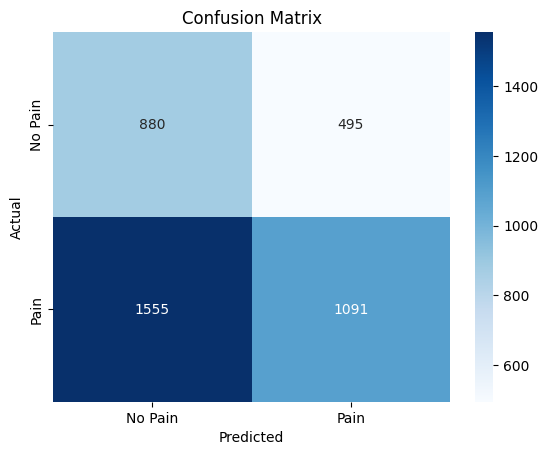

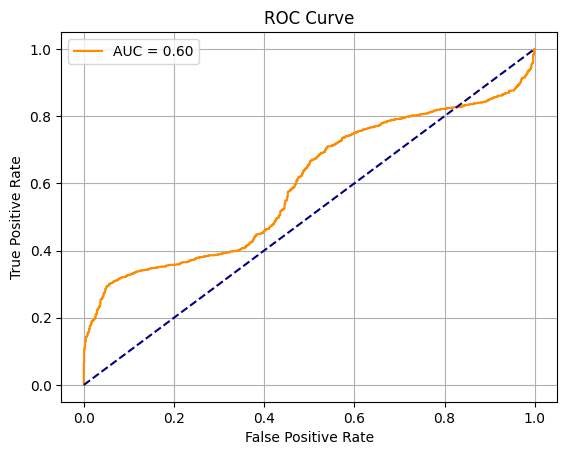

Evaluation complete. Results saved to outputs/test_predictions.csv


In [ ]:
#Loading test dataset
test_data = val_test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=1, class_mode='binary', shuffle=False)
#loading the saved model for evaluation
model = tf.keras.models.load_model("models/resnet50_improved_pain_model.keras", compile=False)

#Predicting on the test dataset
y_true = test_data.classes
y_pred_probs = model.predict(test_data, verbose=1)
y_pred = (y_pred_probs > 0.5).astype('int32')

#Printing classification report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=["No Pain", "Pain"]))

#Calculating the AUC_ROC score
auc = roc_auc_score(y_true, y_pred_probs)
print("AUC-ROC Score:", round(auc, 4))

#Plotting the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Pain", "Pain"], yticklabels=["No Pain", "Pain"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#plotting the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

#Saving the test results into a CSV file for our reference
filenames = test_data.filenames
results = pd.DataFrame({
    "Filename": filenames,
    "True Label": ["No Pain" if x == 0 else "Pain" for x in y_true],
    "Predicted Label": ["No Pain" if x == 0 else "Pain" for x in y_pred.flatten()],
    "Confidence": y_pred_probs.flatten()
})
results.to_csv("test_predictions.csv", index=False)
print("Evaluation complete. Results saved to outputs/test_predictions.csv")


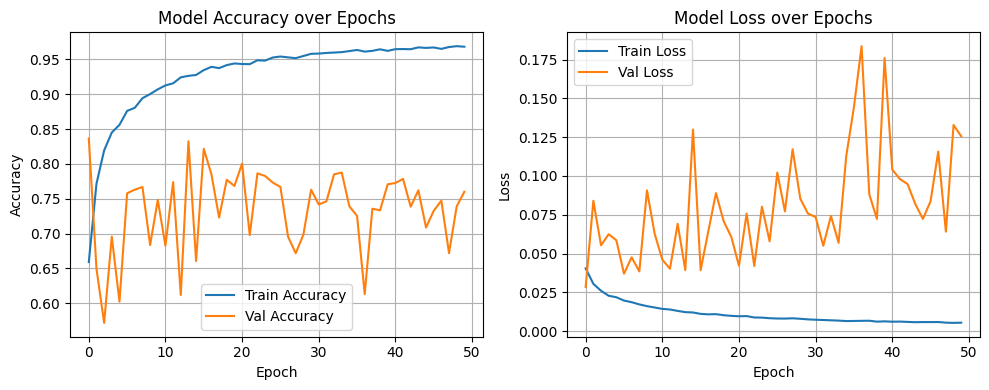

In [ ]:
import matplotlib.pyplot as plt

# Plotting the model performances on epochs
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<Axes: >

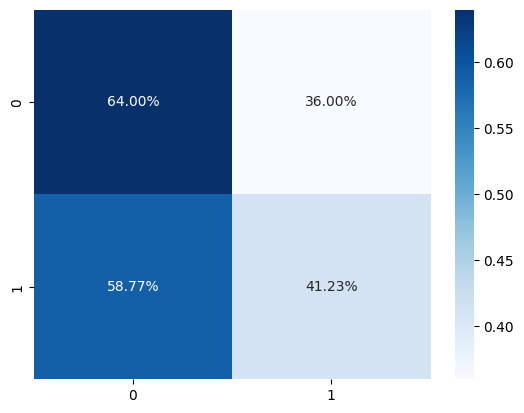

In [ ]:
#Detailed consfusion matrix with percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues")


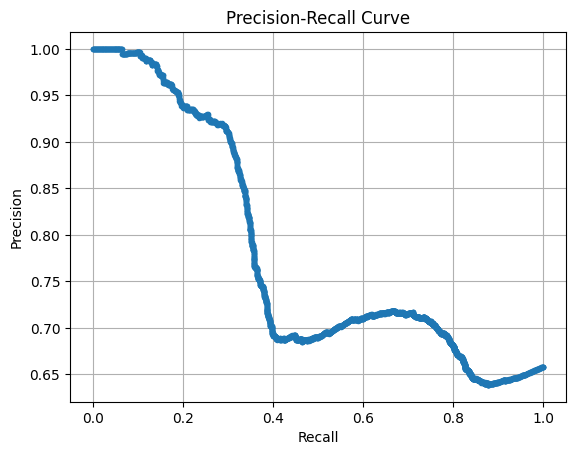

In [ ]:
from sklearn.metrics import precision_recall_curve

#Plotting the Precision Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


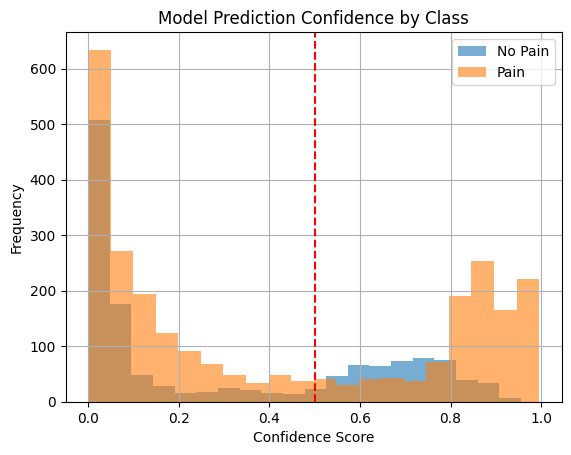

In [ ]:
#Plotting histogram of model prediction confidence by using true label
plt.hist(y_pred_probs[y_true==0], bins=20, alpha=0.6, label='No Pain')
plt.hist(y_pred_probs[y_true==1], bins=20, alpha=0.6, label='Pain')
plt.axvline(0.5, color='red', linestyle='--')
plt.title("Model Prediction Confidence by Class")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
#Analyzing the top false positives and false negatives
results_df = pd.DataFrame({
    "Filename": test_data.filenames,
    "True Label": y_true,
    "Predicted Label": y_pred.flatten(),
    "Confidence": y_pred_probs.flatten()
})

# Filter top errors
fp = results_df[(results_df["True Label"] == 0) & (results_df["Predicted Label"] == 1)].sort_values(by="Confidence", ascending=False)
fn = results_df[(results_df["True Label"] == 1) & (results_df["Predicted Label"] == 0)].sort_values(by="Confidence")

print("Top False Positives:\n", fp.head())
print("Top False Negatives:\n", fn.head())


Top False Positives:
                  Filename  True Label  Predicted Label  Confidence
521   No_pain/049 (2).jpg           0                1    0.955194
388       No_pain/008.jpg           0                1    0.933973
429       No_pain/009.jpg           0                1    0.932239
1364      No_pain/576.jpg           0                1    0.924899
1365      No_pain/577.jpg           0                1    0.912489
Top False Negatives:
                Filename  True Label  Predicted Label  Confidence
2774      Pain/1000.jpg           1                0    0.000006
2772  Pain/1000 (2).jpg           1                0    0.000006
1681  Pain/0345 (2).jpg           1                0    0.000007
1683      Pain/0345.jpg           1                0    0.000007
1708      Pain/0353.jpg           1                0    0.000011
